# Intraretinal cyst fluid detection using Deep Learning

*Abstract— This work aims to do an experimental analysis of recent state of the art deep learning algorithms to find three retinal fluid types, with annotated images provided by two clinical centers, which were acquired with the three most common [OCT] https://en.wikipedia.org/wiki/Optical_coherence_tomography) device vendors from
patients with two different retinal diseases*.  

The rest of the project can be found on the [intraretinal-cyst-fluid-detection](project https://github.com/gabrielraya/intraretinal-cyst-fluid-detection) repository on Github.


## Overview

This is a introductory notebook to undertand the problem of cyst fluid detection, for this we are going to implement and apply some basic image processing techniques to first get familiar with the medical imaging data this project uses.


We will implement the following techniques:
1. conversion of raw mammography data into a gray-scale image
2. stain normalization in digital pathology with histogram matching
3. trachea detection in chest CT with blob detection

## Libraries

In [ ]:
# First make sure you have install these two libraries:
!pip install SimpleITK
!pip install -U pydicom

First, we import the basic libraries necessary to develop this assignment. Feel free to include more libraries if needed.


In [217]:
import requests
import zipfile
from tqdm import tnrange, tqdm_notebook
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import numpy as np
from PIL import Image
import pydicom as dicom
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D
import copy
matplotlib.rcParams['figure.figsize'] = [20, 12]
import scipy.signal

## Data

The data necessary to develop the code in can be downloaded at [https://drive.google.com/open?id=1Y2XKig36mh2WuJ-1ArJWoF-tlgKp8UnT](https://drive.google.com/open?id=1Y2XKig36mh2WuJ-1ArJWoF-tlgKp8UnT).
Please, first download and import the data using the method you like the most, so far I only import it and then uncompress it  ```cyst_segmentation_ISMI_training_set.zip```. After the file is unzipped, it is removed.

In [ ]:
# Only run this code when using Colab
from google.colab import drive
drive.mount('/content/gdrive')

In [7]:
# Only run this code when using Colab
file_name = "cyst_segmentation_ISMI_training_set.zip"
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")

In [218]:
# Only run this code when working on your local system inside the repository
# define your local directory where data is stored
data_dir = './cyst_segmentation_ISMI_training_set/images'

In [219]:
!ls './cyst_segmentation_ISMI_training_set'

annotations
data_usage_policy.pdf
images


Check that the downloaded folder contains the following structure:
````
cyst_segmentation_ISMI_training_set
  |-images
    |-pat001_im001.mdh
    |-pat001_im001.raw
    |-...
  |-annotations
    |-pat001_im001.mhd
    |-pat001_im001.zraw
    |-...
````

### 1. Data Inspection

This first part consists in reconstructing the given images from the raw data acquired with the tommoography machine. There are several steps that have to be applied to reconstruct a gray-scale image that can actually be read by radiologists with the aim of detecting tumors, masses, cysts, micro-calcifications.

### Read image

In your local data folder, you can find a file containing raw mammography data and the corresponding processed gray-level version. The processed version comes from the vendor and is the result of several filtering and enhancement steps that are proprietary. Our goal is however to do a good job at deriving a gray-level image from raw data.
The files are in ITK format, with extension ````.mhd````, and can be opened using the library ````SimpleITK````. You can find documentation on ````SimpleITK```` at this link: http://www.simpleitk.org/SimpleITK/help/documentation.html.
In the next cell, we provide the function used to read the raw data and the gray-level images.
Furthermore, we indicate which steps have to be implemented.
Complete the assignment by implementing the steps indicated.

In [220]:
# raw data in ITK format
raw_img_filename = './cyst_segmentation_ISMI_training_set/images/pat001_im001.mhd'
out_img_filename = './cyst_segmentation_ISMI_training_set/annotations/pat001_im001.mhd'

# read ITK files using SimpleITK
raw_img = sitk.ReadImage(raw_img_filename)
out_img = sitk.ReadImage(out_img_filename)

# print image information
print('image size: {}'.format(raw_img.GetSize()))
print('image origin: {}'.format(raw_img.GetOrigin()))
print('image spacing: {}'.format(raw_img.GetSpacing()))
print('image width: {}'.format(raw_img.GetWidth()))
print('image height: {}'.format(raw_img.GetHeight()))
print('image depth: {}'.format(raw_img.GetDepth()))

image size: (508, 496, 18)
image origin: (1.3379, 0.00585, 2.70800000219485)
image spacing: (0.011500000022351742, 0.0038999998942017555, 0.24135294556617737)
image width: 508
image height: 496
image depth: 18


<font color="blue">
**Question:**
What is the pixel size of this image?
</font>

*A = the resolution of the image is 496 x 508 px, which give a total of <b>251968</b> pixeles. 
This image conttains 18 slides we can use to detect the cyst*

### Convert ITK image to Numpy array

In order to easily manipulate data, it is convenient to convert it into a numpy format, which can be transformed using the numpy library, and can easily be visualized using the ````pylab/matplotlib```` library.
Please check the documentation in http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/01_Image_Basics.html to find the proper function to transform the SimpleITK image to numpy. Write your code below:
* ````out_np````: should contain the numpy array from ````out_img````
* ````raw_np````: should contain the numpy array from ````raw_img````

Note: If you are not familiar with Numpy, you can check briefly this tutorial: http://cs231n.github.io/python-numpy-tutorial/

### NOTE
In the rest of this notebook, several cells will contain variables declared as ````None````.
This means that you have to replace ````None```` with your own code.
We have included checks using the ````assert()```` function to notify that you cannot move to next cells without having replaced ````None```` with a valid expression. 

In [222]:
# convert the ITK image into numpy format
out_np = sitk.GetArrayFromImage(out_img)
raw_np = sitk.GetArrayFromImage(raw_img)

In [223]:
matplotlib.rcParams['figure.figsize'] = [20, 12]

In [224]:
out_np[0].shape

(496, 508)

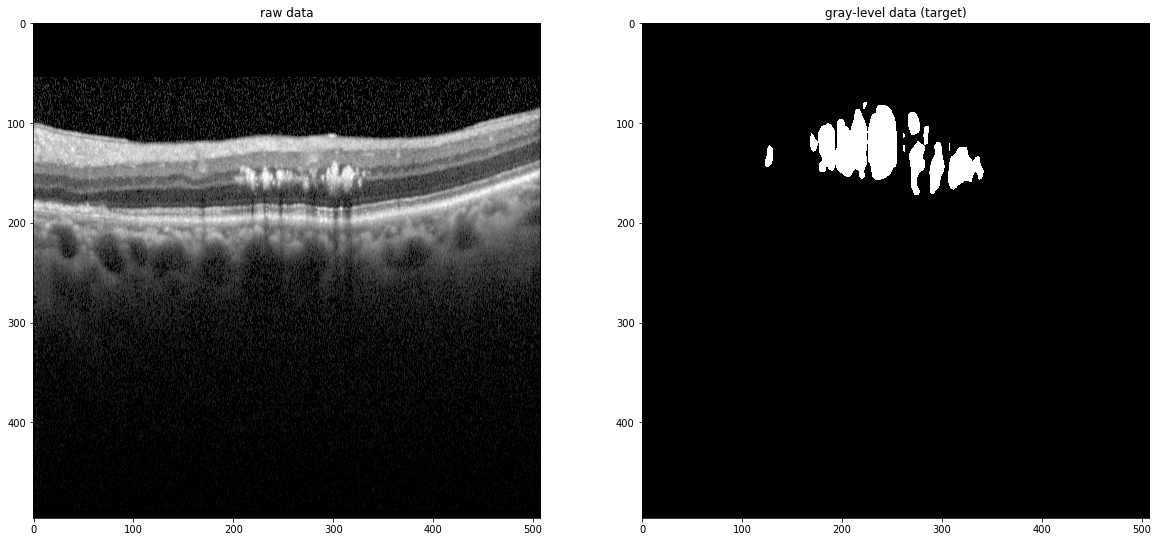

In [225]:
assert(out_np is not None),"out_np cannot be None"
assert(raw_np is not None),"raw_np cannot be None"

# visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np[0], cmap='gray')
plt.title('raw data')
plt.subplot(1,2,2)
plt.imshow(out_np[11], cmap='gray')
plt.title('gray-level data (target)')
plt.show()

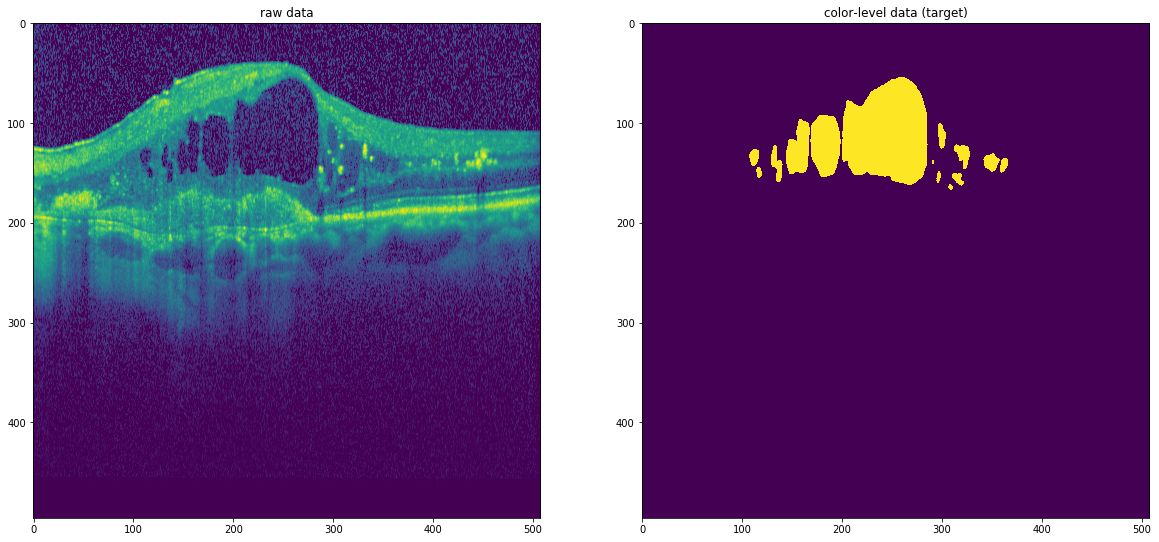

In [226]:
assert(out_np is not None),"out_np cannot be None"
assert(raw_np is not None),"raw_np cannot be None"

# visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np[10])
plt.title('raw data')
plt.subplot(1,2,2)
plt.imshow(out_np[10])
plt.title('color-level data (target)')
plt.show()

### Image processing

In [227]:
DATA_FOLDER = './cyst_segmentation_ISMI_training_set/'

def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))

In [229]:
# get path names list of raw data in ITK format
x_img_files = get_file_list(os.path.join(DATA_FOLDER,'images/'), 'mhd')
y_img_files = get_file_list(os.path.join(DATA_FOLDER,'annotations/'), 'mhd')

# read ITK files using SimpleITK and conver then into a list of numpy arrays
X = [load_img(f) for f in x_img_files]
Y = [load_img(f) for f in y_img_files]

Let's verify the number of X sample files is the same as the number of annotated images Ys.

In [240]:
print("Number of samples X:{} , Y:{}".format(len(x_img_files),len(y_img_files)))
print("Number of samples X:{} , Y:{}".format(len(X),len(Y)))

Number of samples X:122 , Y:122
Number of samples X:122 , Y:122


In [239]:
# Test
print(x_img_files[0])
raw_np =  sitk.GetArrayFromImage(sitk.ReadImage(x_img_files[0]))
print(raw_np.shape)

./cyst_segmentation_ISMI_training_set/images/pat001_im001.mhd
(18, 496, 508)


In [241]:
def show_image(img, lbl):
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    s, h, w = img.shape 
    for i in range(s):
        plt.subplot(1,2,1)
        plt.imshow(img[i])
        plt.title('RGB image')

        plt.subplot(1,2,2)
        plt.imshow(lbl[i])
        plt.title('Manual annotation')
        plt.show()

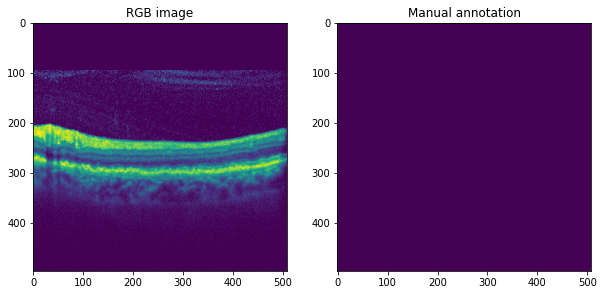

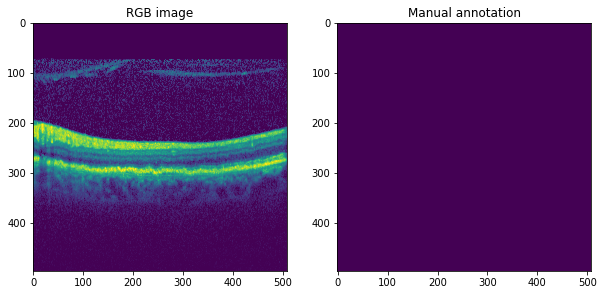

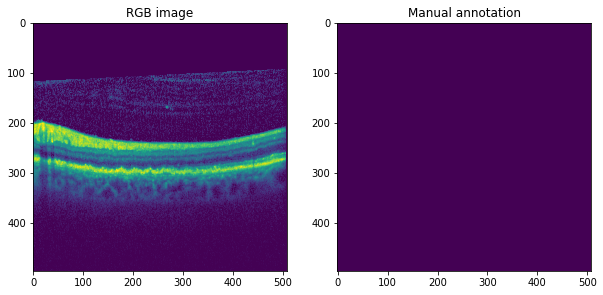

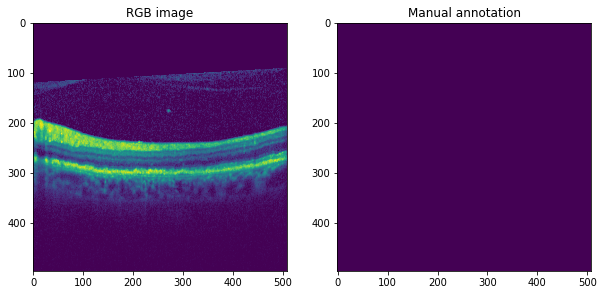

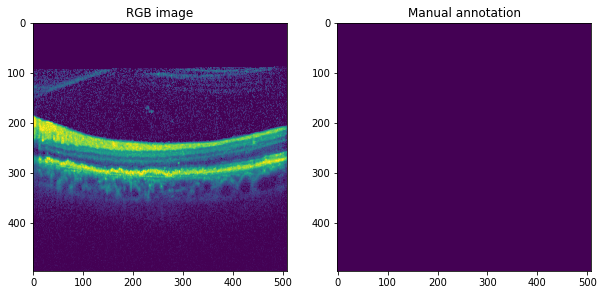

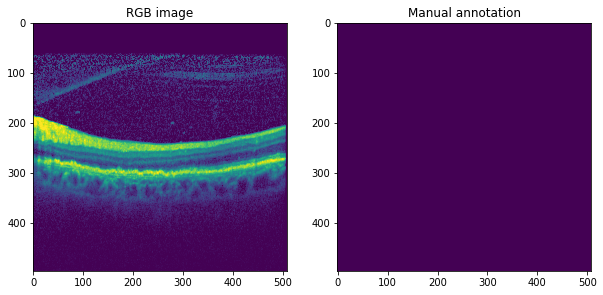

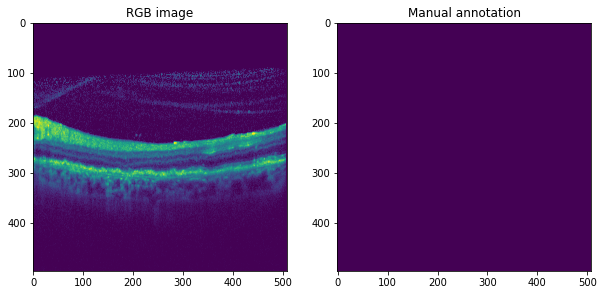

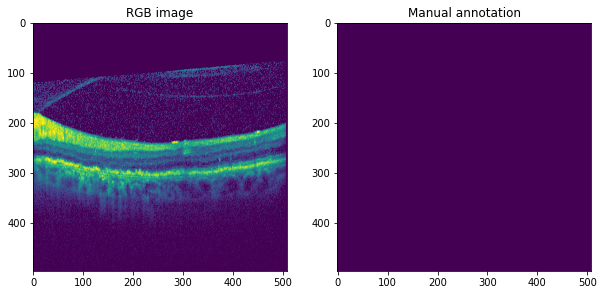

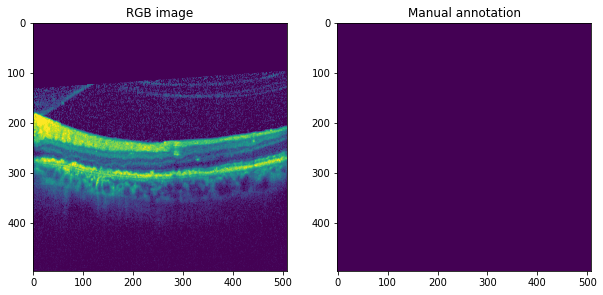

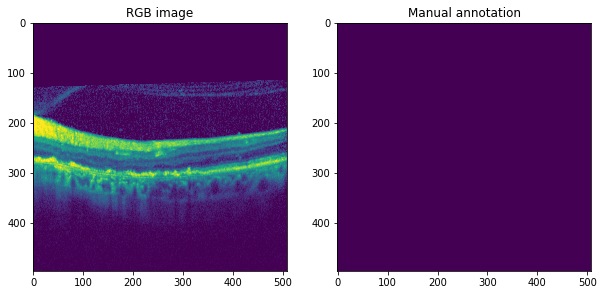

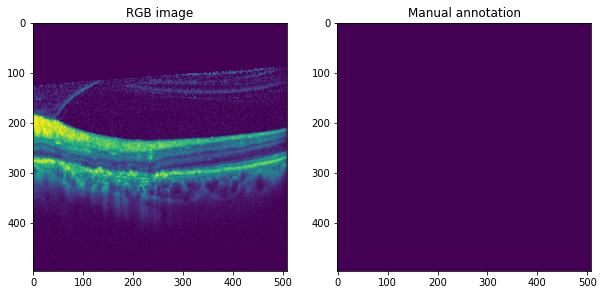

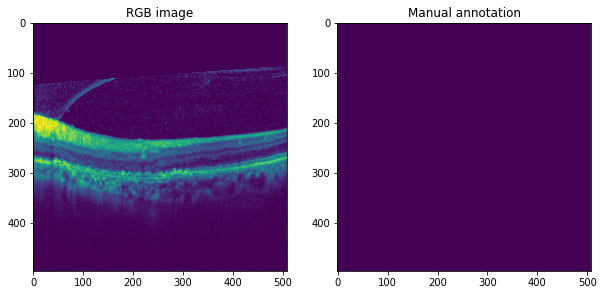

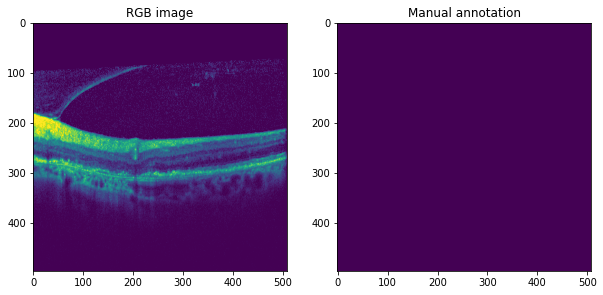

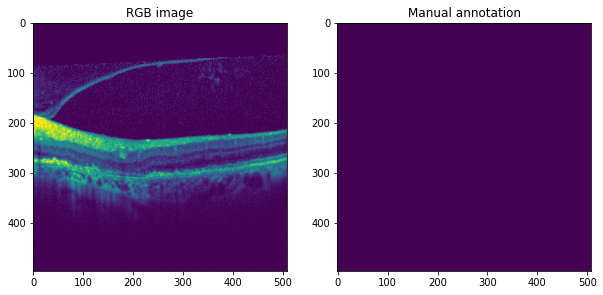

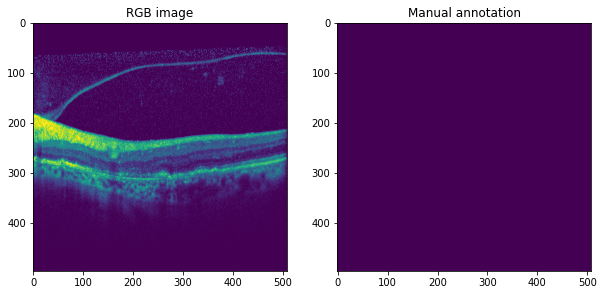

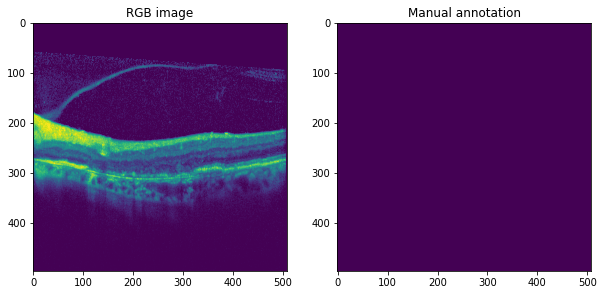

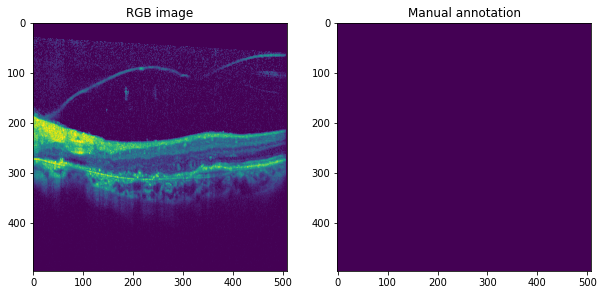

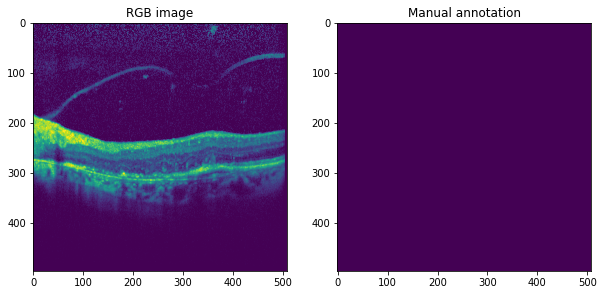

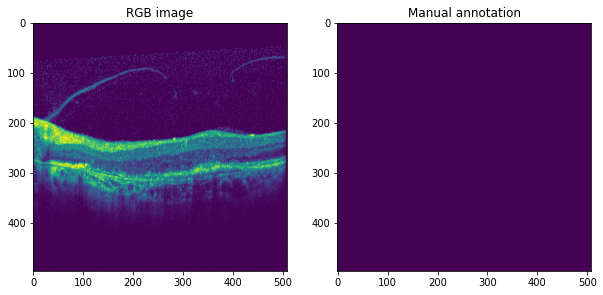

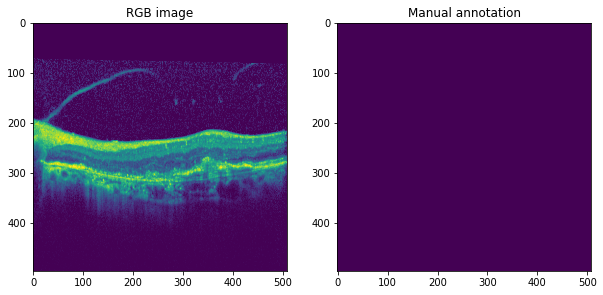

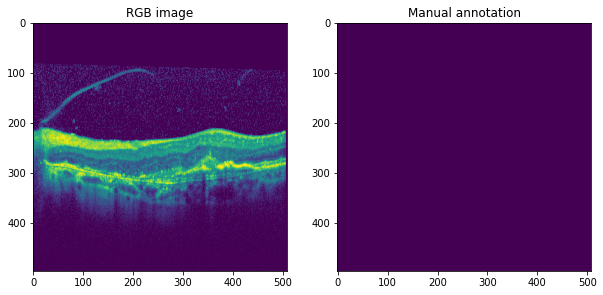

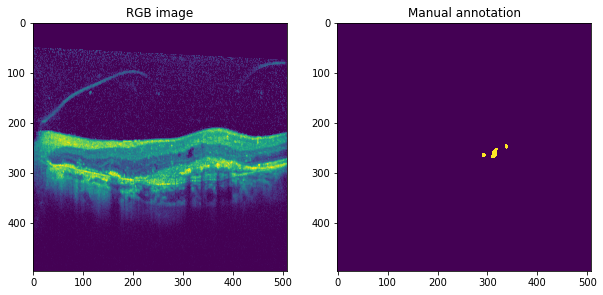

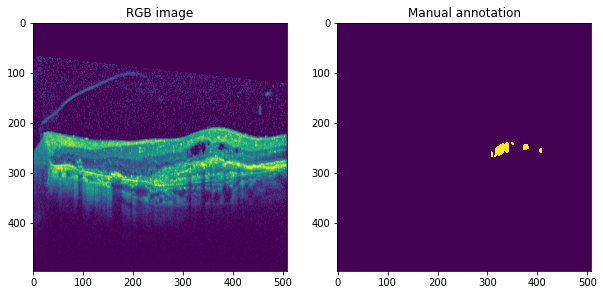

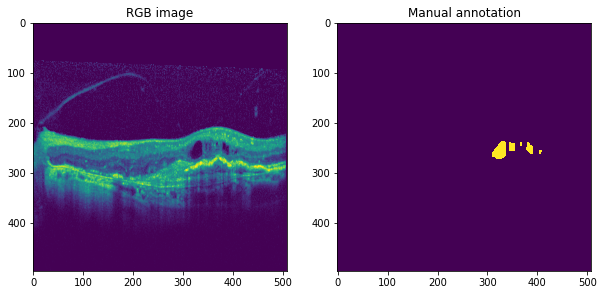

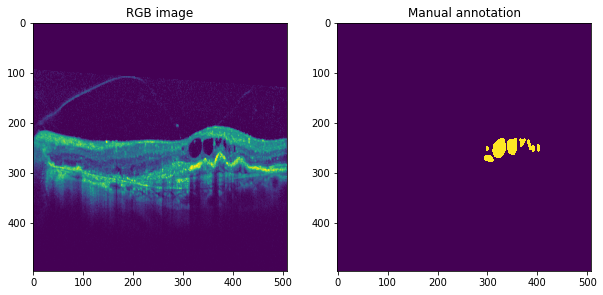

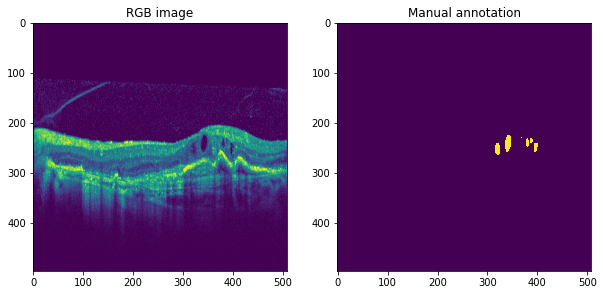

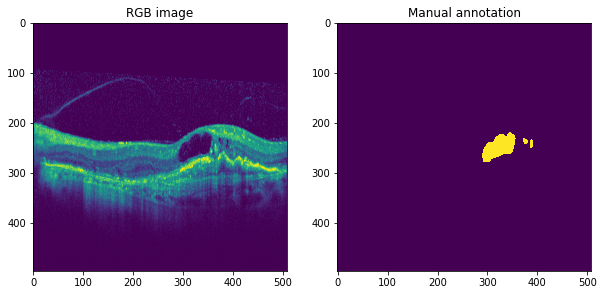

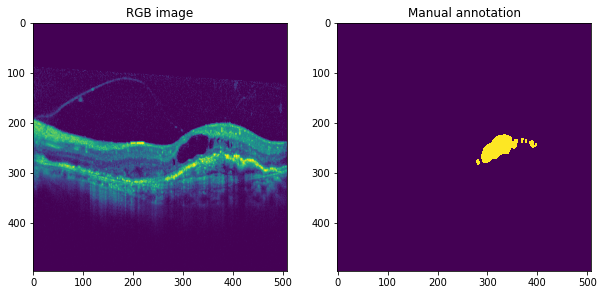

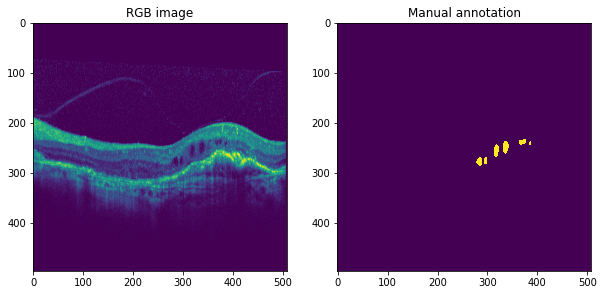

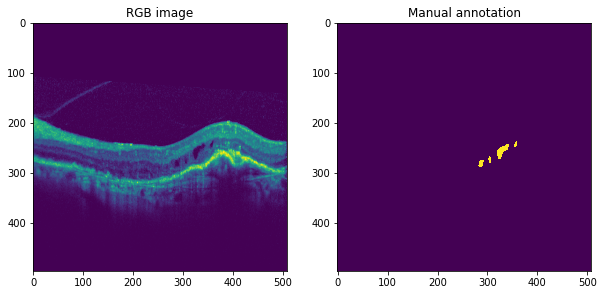

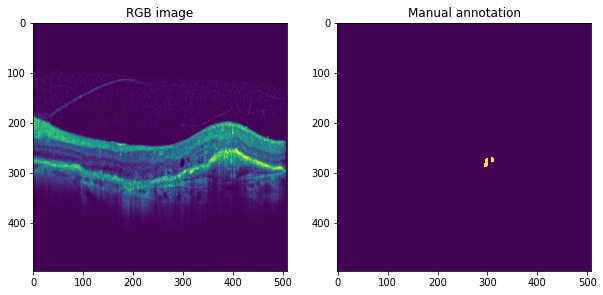

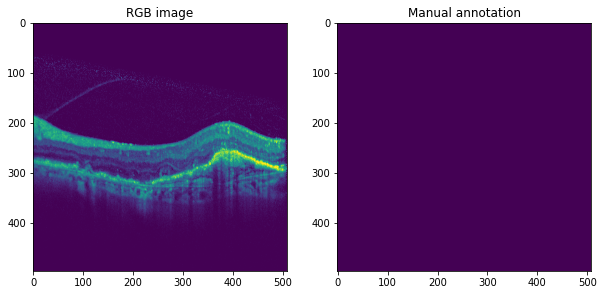

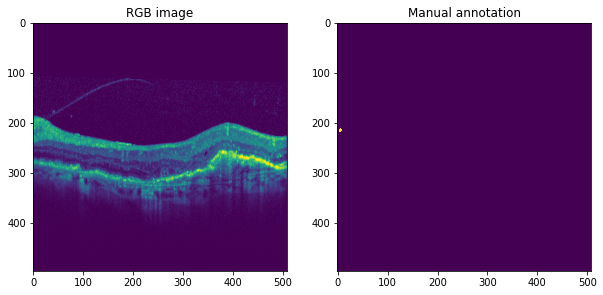

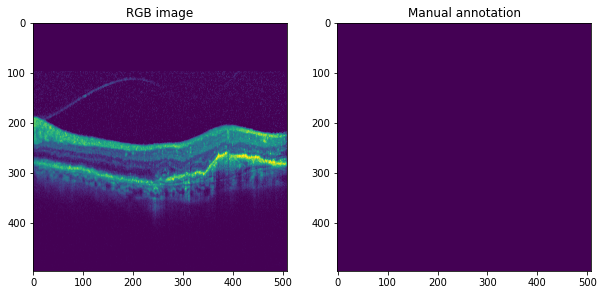

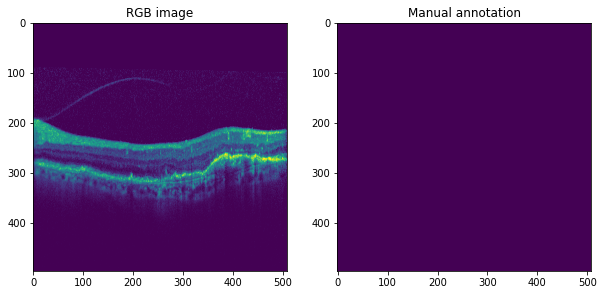

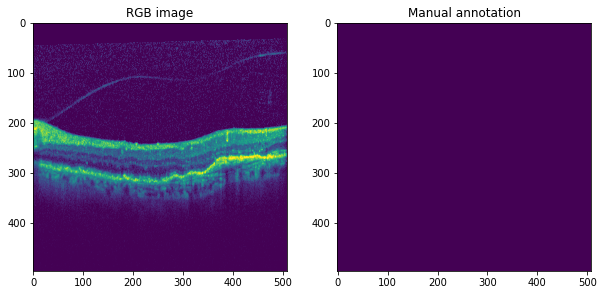

In [242]:
i = 19# Try some values here    
show_image(X[i], Y[i])

In [273]:
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None:
            f, axes   = plt.subplots(1, 2)
            img_slice = self.imgs[i]
            lbls_slice= self.lbls[i]
            s = img_slice.shape[0]
            for ax, im, t in zip(axes, 
                                 (img_slice[i], lbls_slice[i]), 
                                 ('RGB image', 
                                  'Manual annotation; Range: [{}, {}]'.format(self.lbls[i].min(), 
                                                                              self.lbls[i].max()))):
                ax.imshow(im)
                ax.set_title(t)
        else:
            plt.imshow(self.imgs[i])
            plt.title('RGB image')
        plt.show()
        
        


Images in the training set are currently in the same order as read from disk. To avoid any bias possibly introduced by this order, it is always good to shuffle the training dataset. Note that images and annotations must be shuffled in the same way!

In [258]:
import random
# shuffle order of training images and manual annotations
indexes = list(range(len(X)))
random.shuffle(indexes)
indexes

train_imgs = list(np.asarray(X)[indexes])
train_lbls = list(np.asarray(Y)[indexes])

In [261]:
train_imgs[0].shape

(18, 496, 508)

In [264]:
len(train_imgs)

122

### Split into training and validation set
Now we can define a training and a validation set by using the Dataset class that we have defined. In order to define a validation set, you have to specify a coefficient (from 0 to 1) to indicate the percentage of training images that you want to use for validation (we have seen that typical splits are 70/30, 80/20 etc.

In [265]:
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)

In [268]:
n_validation_imgs = int(validation_percent * len(train_imgs))

# use the first images as validation
validation_dataset = DataSet(train_imgs[:n_validation_imgs], train_lbls[:n_validation_imgs])

# the rest as training
training_dataset = DataSet(train_imgs[n_validation_imgs:], train_lbls[n_validation_imgs:])

# test dataset
#test_dataset = DataSet(test_imgs)

n_tra_imgs = training_dataset.get_lenght()
n_val_imgs = validation_dataset.get_lenght()
#n_tes_imgs = test_dataset.get_lenght()

print('{} training images'.format(n_tra_imgs))
print('{} validation images'.format(n_val_imgs))
#print('{} test images'.format(n_tes_imgs))

98 training images
24 validation images


### Visualize datasets
Let's visualize images in the training, the validation and the test set.

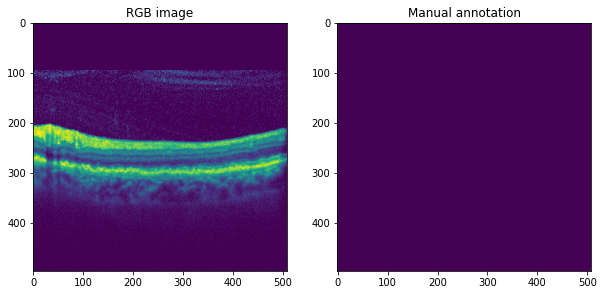

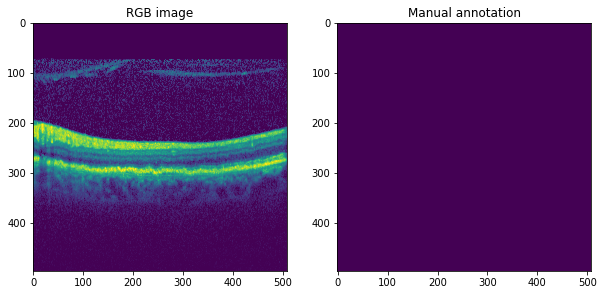

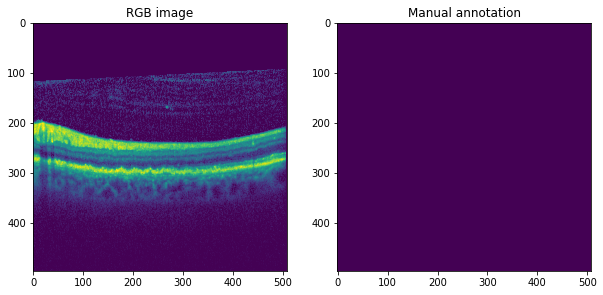

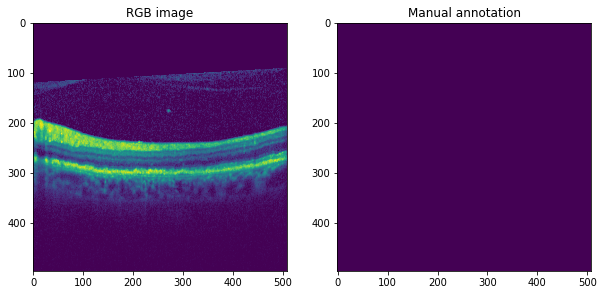

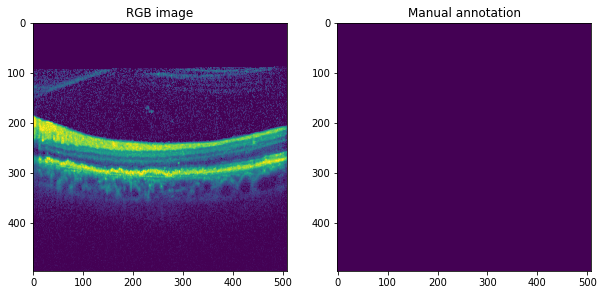

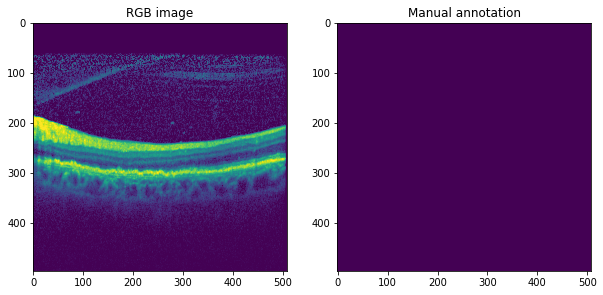

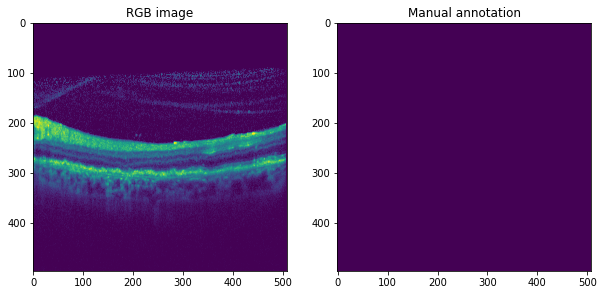

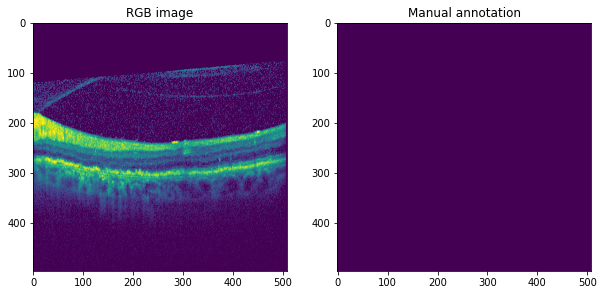

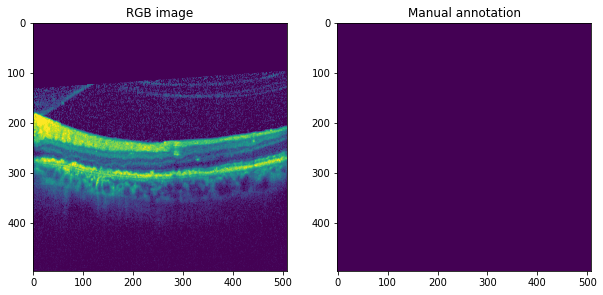

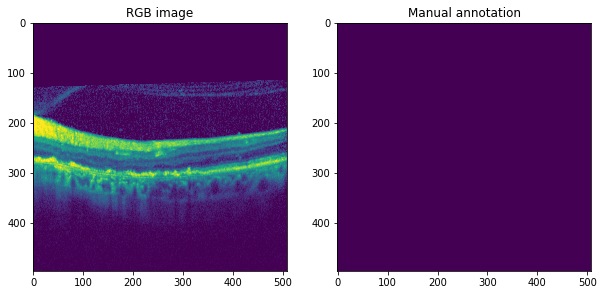

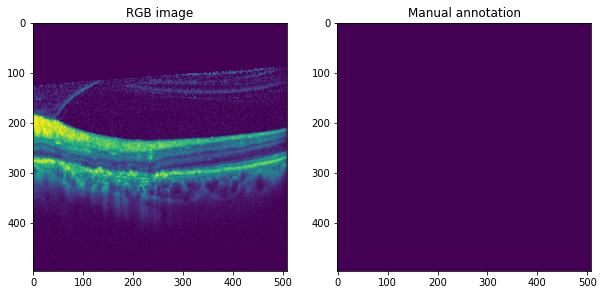

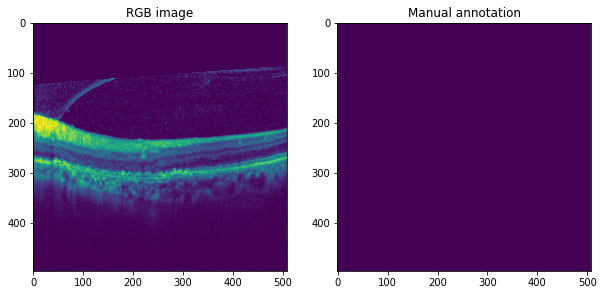

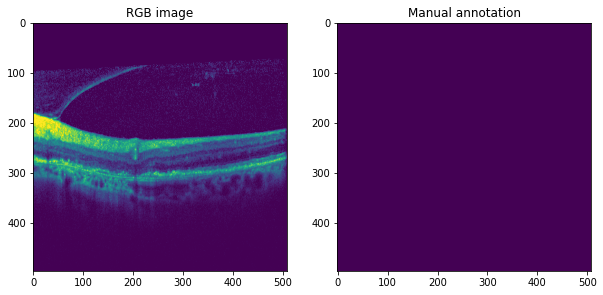

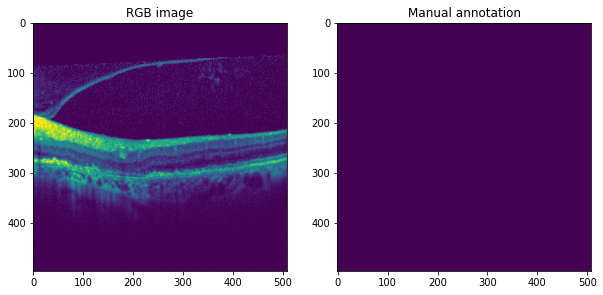

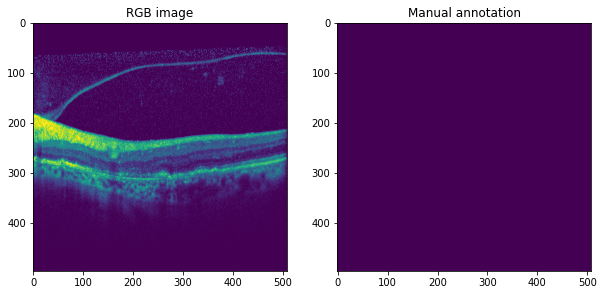

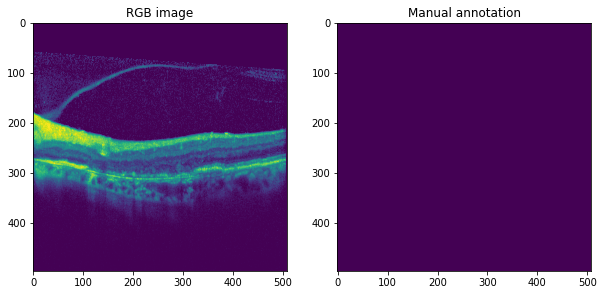

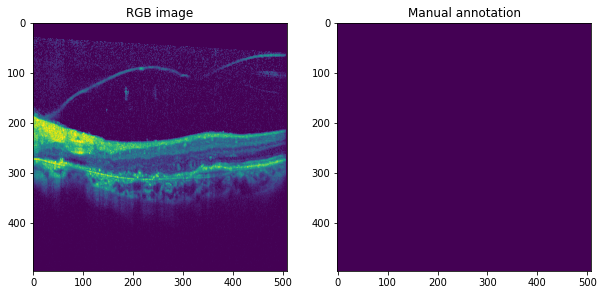

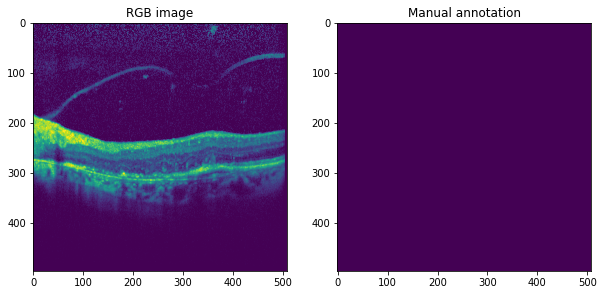

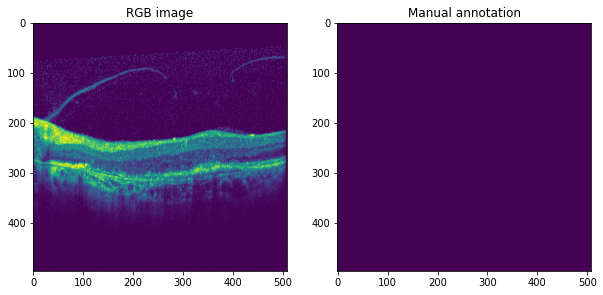

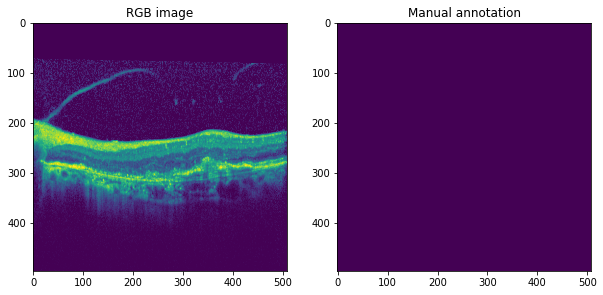

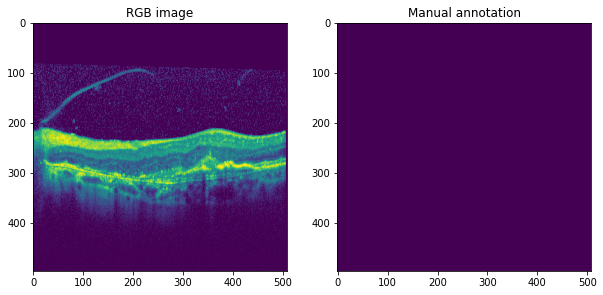

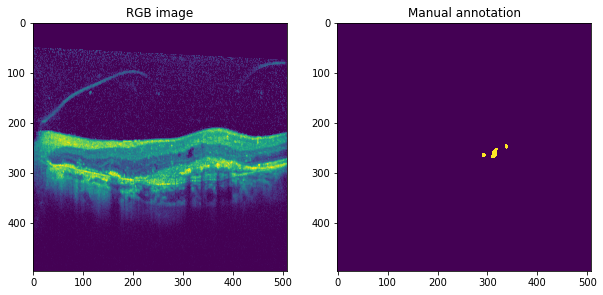

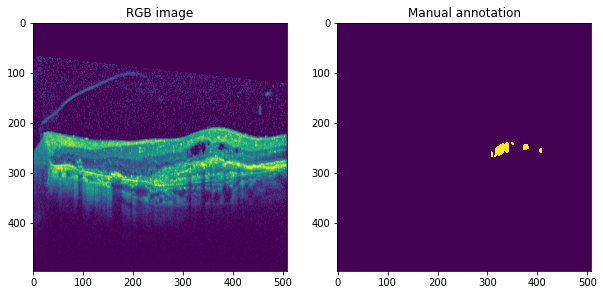

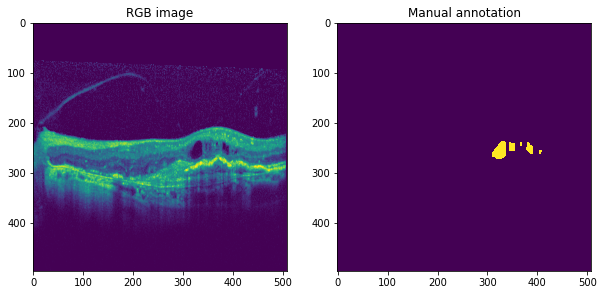

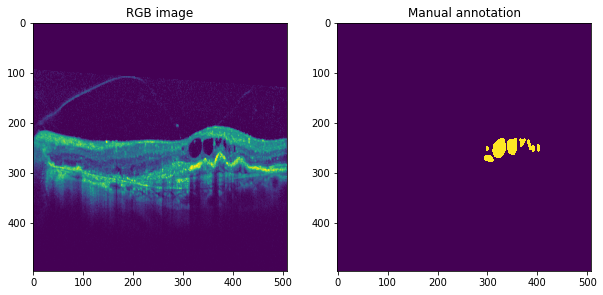

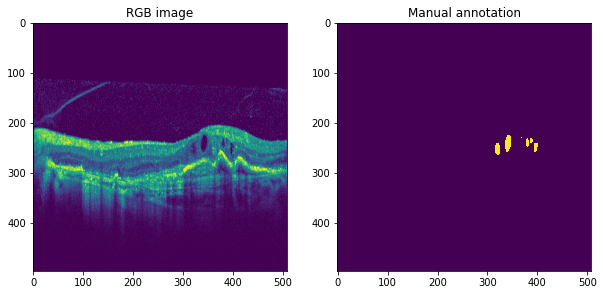

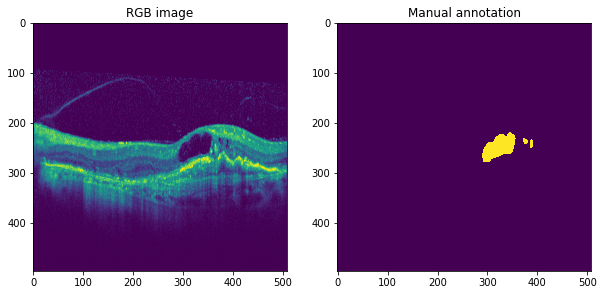

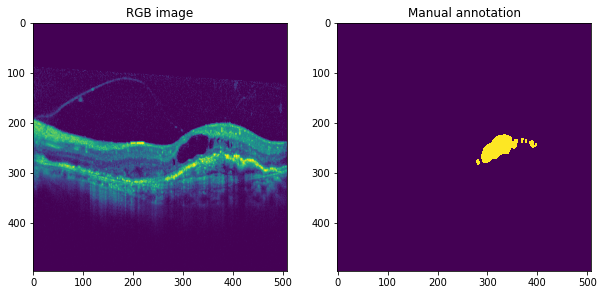

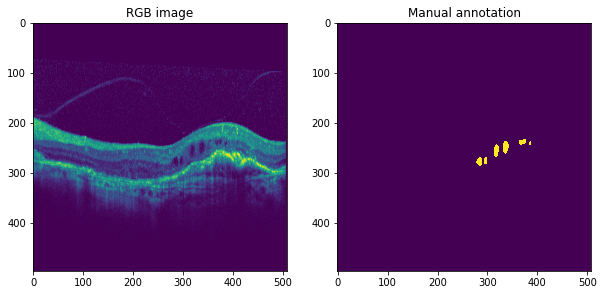

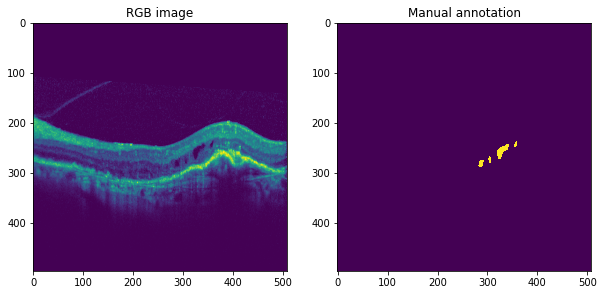

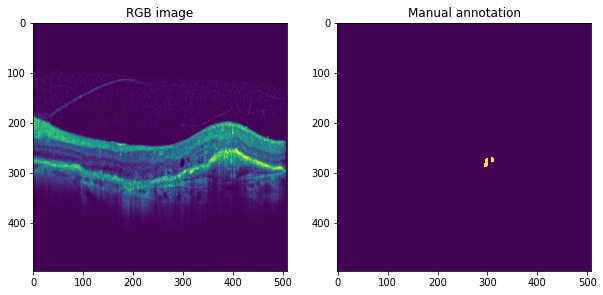

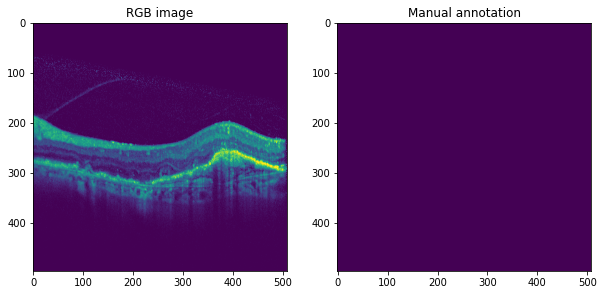

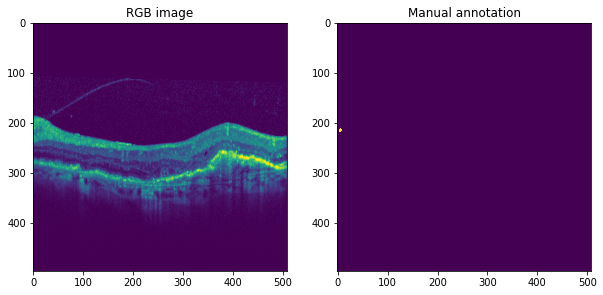

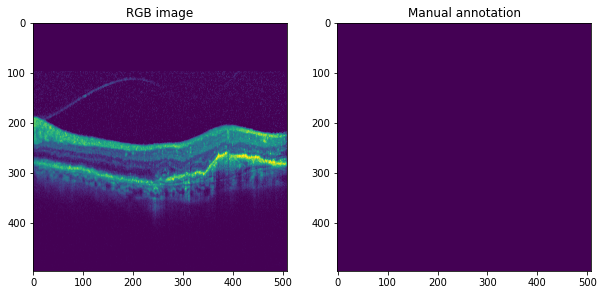

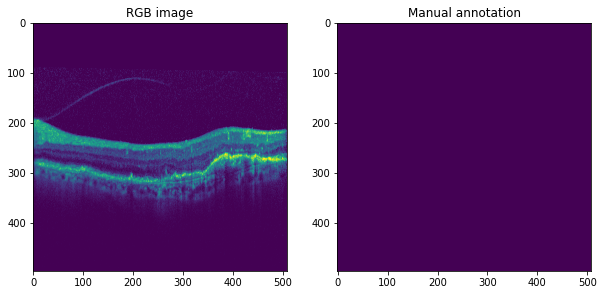

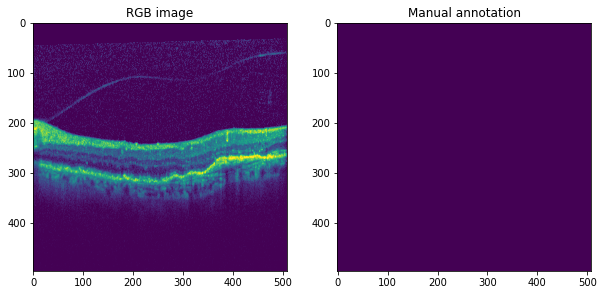

In [275]:
# training set
#for i in range(n_tra_imgs):
#    training_dataset.show_image(i)
    
i = 19# Try some values here    
show_image(X[i], Y[i])